In [1]:
import glob
import os
import cv2
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm
import itertools


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

## Load Data

In [2]:
def get_data_as_nparray(dir):
    data = []
    for i, image_path in enumerate(glob.glob(os.path.join(dir,'*.jpg'))):
        if i > 5:
            continue
        img = cv2.imread(image_path) # (height,width,channels)
        img_expanded = np.expand_dims(img,axis=0) # (1,height,width,channels)
        data.append(img_expanded)
    # (n_samples,height,width,channels)
    data_np = np.concatenate(data,axis=0)
    return data_np

def show_imgs(imd_data,height,width):
    %matplotlib inline
    # Show multi img
    plt.figure(figsize=(12,12))
    for i,d in enumerate(imd_data):
        if i >= width*height:         
            continue
        plt.subplot(height,width,i+1)
        plt.imshow(ｄ)

In [3]:
style_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
# monet_data = get_data_as_nparray(style_dir)
# show_imgs(monet_data,2,3)

In [4]:
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
# photo_data = get_data_as_nparray(photo_dir)
# show_imgs(photo_data,1,3)


## random,torch再現性確保
[reference](https://www.google.com/search?q=++++torch.backends.cudnn.deterministic+qiita&sxsrf=AOaemvKxBaC4koa_BLVExQIaGCbCwYaxHg%3A1630678601472&ei=SS4yYdejHI7_0ASTyIuQAg&oq=++++torch.backends.cudnn.deterministic+qiita&gs_lcp=Cgdnd3Mtd2l6EAM6BwgjELADECdKBAhBGAFQnBZYnBZgyx5oAXAAeACAAT2IAT2SAQExmAEAoAECoAEByAEBwAEB&sclient=gws-wiz&ved=0ahUKEwiX7KGW_-LyAhWOP5QKHRPkAiIQ4dUDCA4&uact=5)

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)   # pythonのハッシュベースの操作の再現性を担保
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False      # False:再現性確保 True：速度確保
    torch.backends.cudnn.deterministic = True   # PyTorchの操作の中には非決定的なものがあります。それらを決定的なものにします。

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
seed = 95
set_seed(seed)

## Dataset作成
[reference](https://qiita.com/kumonk/items/0f3cad018cc9aec67a63)

In [8]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, style_dir, photo_dir, imageSize=(256,256), transform=None, normalize=True):
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(imageSize), 
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(imageSize), 
                transforms.ToTensor(), 
            ])
        # Dataのパスリスト
        self.style_paths = [str(p) for p in Path(style_dir).glob("*.jpg")]
        self.photo_paths = [str(p) for p in Path(photo_dir).glob("*.jpg")]

        self.data_num = min(len(self.style_paths),len(self.photo_paths)) # ここが__len__の返り値になる
        
        # Dataのラベルリスト
        # self.classes = ['carpet', 'ceramic', 'cloth', 'dirt', 'drywall', 'glass', 'grass', 'gravel', 'leaf', 'metal']
        # self.class_to_idx = {'carpet':0, 'ceramic':1, 'cloth':2, 'dirt':3, 'drywall':4, 'glass':5, 'grass':6,'gravel':7, 'leaf':8, 'metal':9}


    def __getitem__(self, idx):
        s = self.style_paths[idx]
        style_img = PIL.Image.open(s)
        p = self.photo_paths[idx]
        photo_img = PIL.Image.open(p)

        if self.transform:
            out_style = self.transform(style_img)
            out_photo = self.transform(photo_img)            
        
        # ForLabel
        # out_label = p.split("\\")
        # out_label = self.class_to_idx[out_label[3]]

        return out_style, out_photo
        
    def __len__(self):
        return self.data_num

3
torch.Size([3, 256, 256])


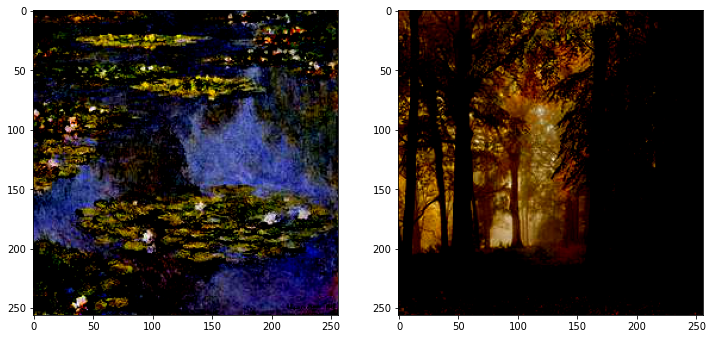

In [9]:
# dataset = MyDataset(style_dir, photo_dir, normalize=False)
dataset = MyDataset(style_dir, photo_dir, normalize=True)
style_img, photo_img = next(iter(dataset))

print(len(style_img))
print(style_img.size())
show_imgs([style_img.permute(1, 2, 0),photo_img.permute(1, 2, 0)],1,2)

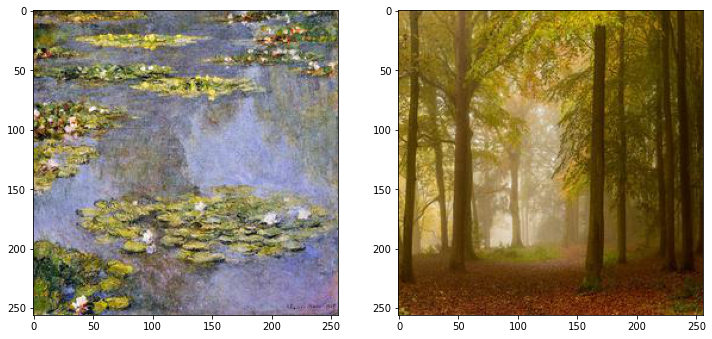

In [10]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)  
    return img

show_imgs([unnorm(style_img).permute(1, 2, 0),unnorm(photo_img).permute(1, 2, 0)],1,2)

## DataLoader再現性確保
[reference](https://www.google.com/search?q=++++torch.backends.cudnn.deterministic+qiita&sxsrf=AOaemvKxBaC4koa_BLVExQIaGCbCwYaxHg%3A1630678601472&ei=SS4yYdejHI7_0ASTyIuQAg&oq=++++torch.backends.cudnn.deterministic+qiita&gs_lcp=Cgdnd3Mtd2l6EAM6BwgjELADECdKBAhBGAFQnBZYnBZgyx5oAXAAeACAAT2IAT2SAQExmAEAoAECoAEByAEBwAEB&sclient=gws-wiz&ved=0ahUKEwiX7KGW_-LyAhWOP5QKHRPkAiIQ4dUDCA4&uact=5)
## DataLoader速度確保
```
num_workers=os.cpu_count()
pin_memory=True
```
[reference](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#12-pin_memory)

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

img_dl = DataLoader(
                        dataset,
                        batch_size=32,
                        num_workers=os.cpu_count(),
                        worker_init_fn=seed_worker,
                        generator=g,
                        pin_memory=True
                    )

## Checkpoint Load and Save

In [12]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

## Model

[ReflectionPad2d](https://teratail.com/questions/254795)

In [13]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )
    
def Convlayer(in_ch, out_ch, kernel_size=3, stride=1, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, use_leaky=True, use_inst_norm=True, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [14]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=2):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, kernel_size=7, stride=1, use_leaky=True, use_inst_norm=True, use_pad=False))
        model.append(Convlayer(64, 128, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True))
        model.append(Convlayer(128, 256, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, stride=1, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=3):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, kernel_size=4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, kernel_size=4, stride=1))
            else:
                model.append(Convlayer(in_chs, out_chs, kernel_size=4, stride=2))
        model.append(nn.Conv2d(out_chs, 1, kernel_size=4, stride=1, padding=1))
#         model.append(nn.Sigmoid())
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [16]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [17]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad
            
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret
    
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

## GAN

In [18]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_s2p = Generator(in_ch, out_ch)
        self.gen_p2s = Generator(in_ch, out_ch)
        self.desc_s = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
#         self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_s2p.parameters(), self.gen_p2s.parameters()),
#                                          lr= start_lr, betas=(0.5, 0.999))
#         self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_s.parameters(), self.desc_p.parameters()),
#                                           lr=start_lr, betas=(0.5, 0.999))
        self.adam_gen = torch.optim.AdamW(itertools.chain(self.gen_s2p.parameters(), self.gen_p2s.parameters()),
                                         lr= start_lr)
        self.adam_desc = torch.optim.AdamW(itertools.chain(self.desc_s.parameters(), self.desc_p.parameters()),
                                          lr=start_lr)
        self.sample_style = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_s2p)
        init_weights(self.gen_p2s)
        init_weights(self.desc_s)
        init_weights(self.desc_p)
        self.gen_s2p = self.gen_s2p.to(self.device)
        self.gen_p2s = self.gen_p2s.to(self.device)
        self.desc_s = self.desc_s.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, style_real) in enumerate(t):
                photo_img, style_img = photo_real.to(device), style_real.to(device)
                update_req_grad([self.desc_s, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_s2p(style_img)
                fake_style = self.gen_p2s(photo_img)

                cycl_style = self.gen_p2s(fake_photo)
                cycl_photo = self.gen_s2p(fake_style)

                id_style = self.gen_p2s(style_img)
                id_photo = self.gen_s2p(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_style = self.l1_loss(id_style, style_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_style = self.l1_loss(cycl_style, style_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                style_desc = self.desc_s(fake_style)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(style_desc.size()).to(self.device)

                adv_loss_style = self.mse_loss(style_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_style + adv_loss_style\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_style + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_s, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_style = self.sample_monet([fake_style.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_style = torch.tensor(fake_style).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                style_desc_real = self.desc_s(style_img)
                style_desc_fake = self.desc_s(fake_style)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(style_desc_real.size()).to(self.device)
                fake = torch.zeros(style_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                style_desc_real_loss = self.mse_loss(style_desc_real, real)
                style_desc_fake_loss = self.mse_loss(style_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                style_desc_loss = (style_desc_real_loss + style_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                style_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_s2p': gan.gen_s2p.state_dict(),
                'gen_p2s': gan.gen_p2s.state_dict(),
                'desc_s': gan.desc_s.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [ ]:
gan = CycleGAN(3, 3, 50, device)
gan.train(img_dl)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

In [ ]:
forcheck_imgs = torch.empty()
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_style = gan.gen_p2s(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_style = unnorm(pred_style)    
    forcheck_imgs= torch.cat((photo_img, pred_style), 0)

show_imgs(forcheck_imgs,5,2)